<a href="https://colab.research.google.com/github/J-a-y-a-shree/BtpFinalAttempt/blob/main/Final_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape: (10573, 29)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10573 entries, 0 to 10572
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Irradiance         10573 non-null  int64  
 1   AmbientTemp        10573 non-null  int64  
 2   rload              10573 non-null  float64
 3   cload              10573 non-null  float64
 4   fc                 10573 non-null  int64  
 5   f_samp             10573 non-null  int64  
 6   Inductor           10573 non-null  float64
 7   Capacitor          10573 non-null  float64
 8   Vpv_avg            10573 non-null  float64
 9   Ipv_avg            10573 non-null  float64
 10  DutyCycleActual    10573 non-null  float64
 11  Vout_avg           10573 non-null  float64
 12  Iout_avg           10573 non-null  float64
 13  P_out              10573 non-null  float64
 14  VoltageRipple_pp   10573 non-null  float64
 15  VoltageRipple_rms  10573 non-null  float64
 16  Cur

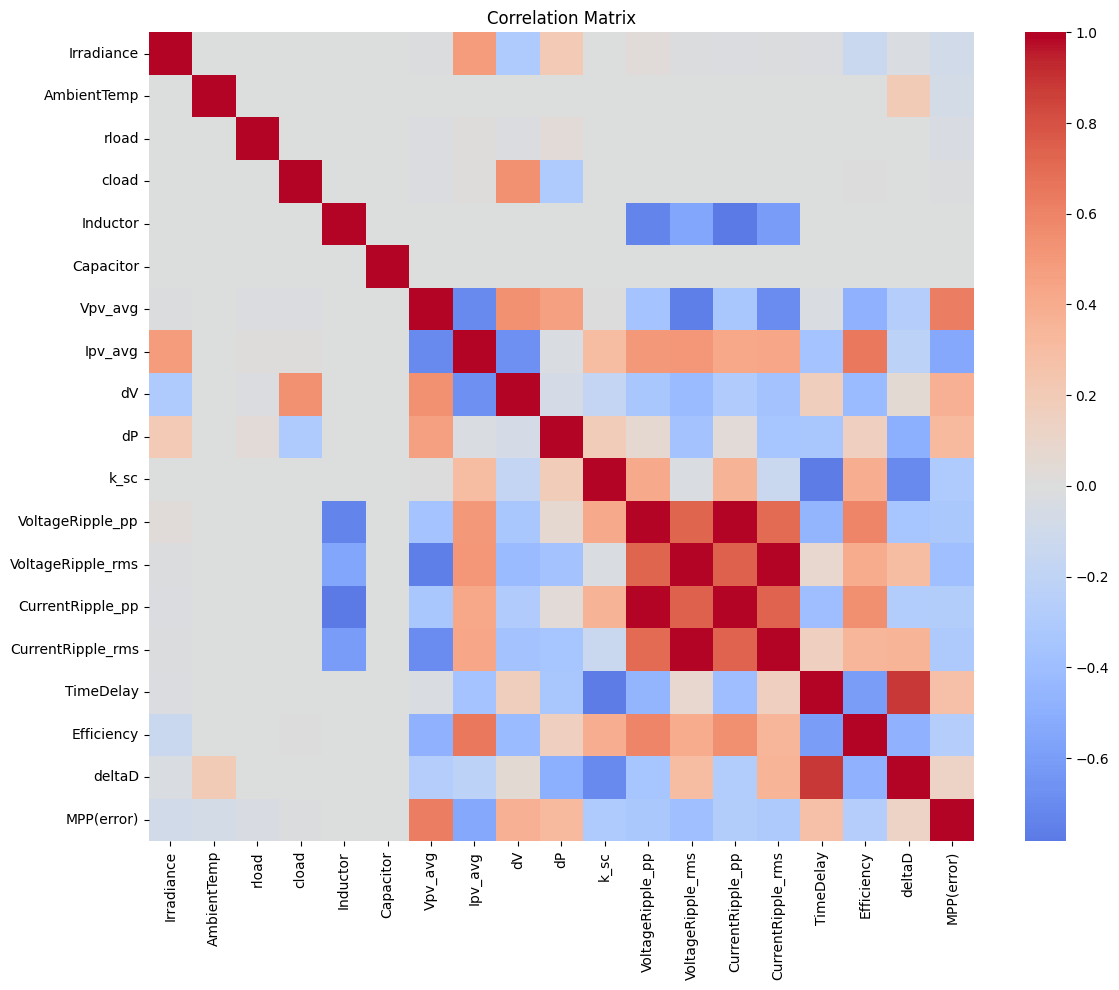

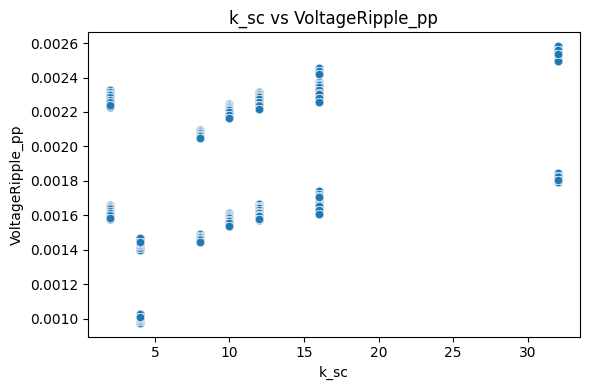

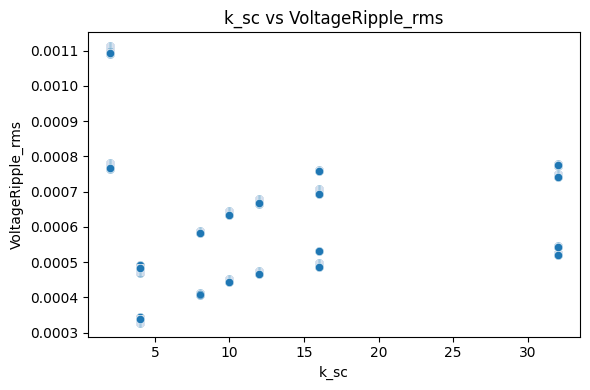

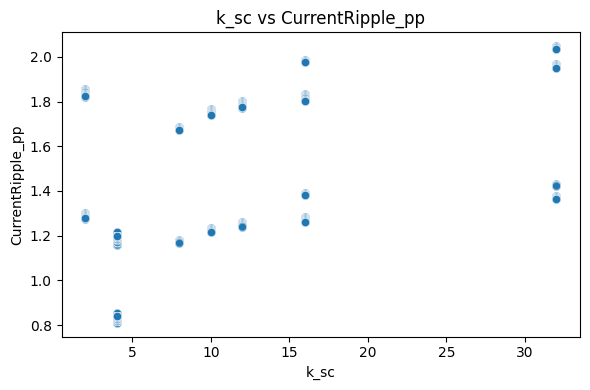

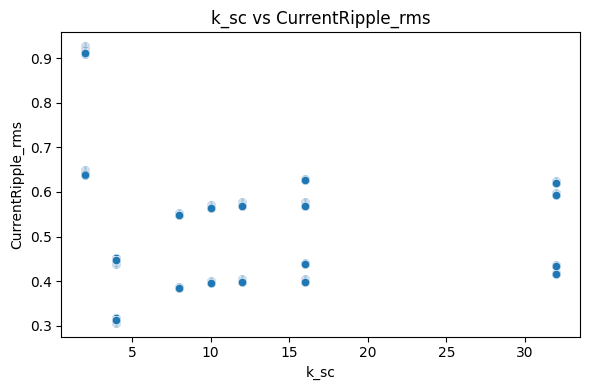

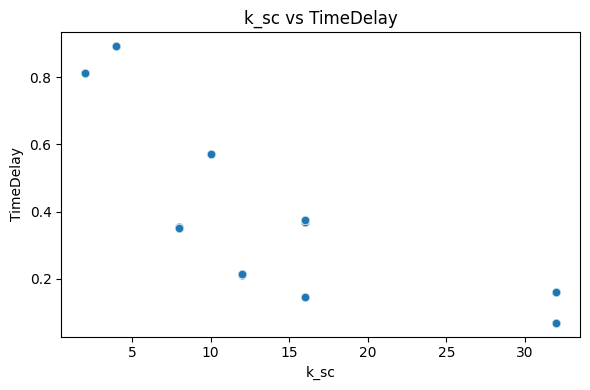

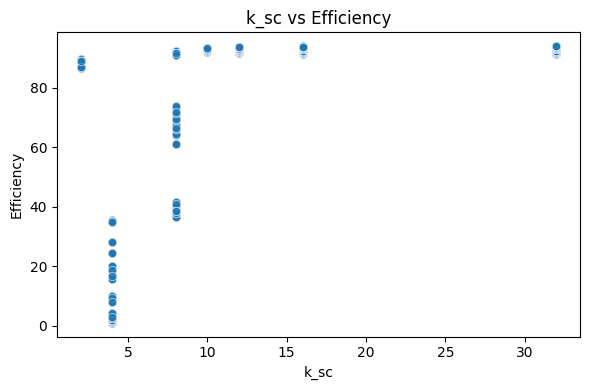

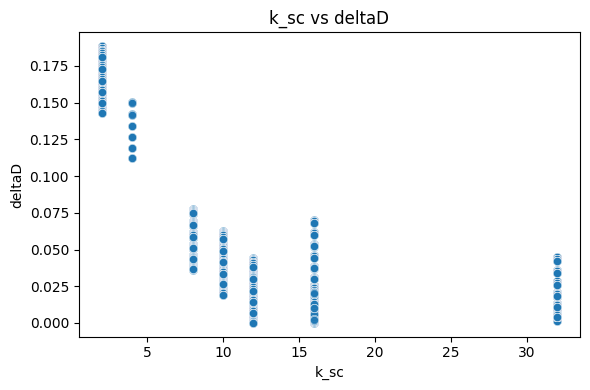

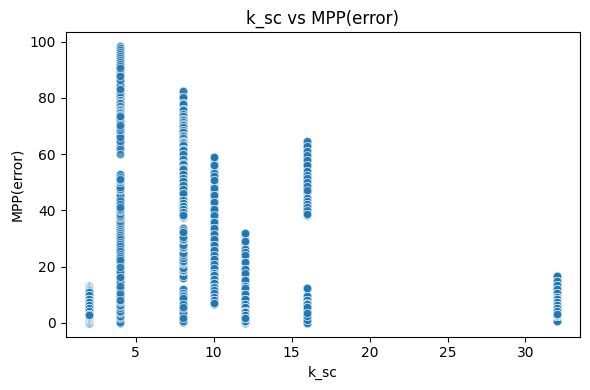

In [1]:
# Phase 1 – EDA & Preprocessing

import pandas as pd
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# 1. Load & inspect
df = pd.read_csv("/content/Final_Dataset10kfinalAttempt.csv")
print("Shape:", df.shape)
print(df.info())
print(df.describe())
print("Missing values:\n", df.isna().sum())

# 2. Define inputs & targets
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor", "Capacitor", "Vpv_avg", "Ipv_avg","dV","dP", "k_sc"
]
target_cols = [
    "VoltageRipple_pp", "VoltageRipple_rms",
    "CurrentRipple_pp", "CurrentRipple_rms",
    "TimeDelay", "Efficiency", "deltaD", "MPP(error)"
]
X = df[input_cols].copy()
y = df[target_cols].copy()

# 3. Handle outliers on each target (clip to 1st–99th percentiles)
for col in target_cols:
    low, high = y[col].quantile([0.01, 0.99])
    y[col] = y[col].clip(low, high)

# 4. Group-split to train/val/test (by unique combinations of features excluding k_sc)
group_cols = ["Irradiance", "AmbientTemp", "rload", "cload", "Inductor", "Capacitor", "Vpv_avg", "Ipv_avg","DutyCycleActual","dV","dP"]
df["group_key"] = df[group_cols].astype(str).agg("_".join, axis=1)

gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, temp_idx = next(gss.split(df, groups=df["group_key"]))

temp_df = df.iloc[temp_idx]
gss2 = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx_rel, test_idx_rel = next(gss2.split(temp_df, groups=temp_df["group_key"]))

val_idx  = temp_df.index[val_idx_rel]
test_idx = temp_df.index[test_idx_rel]

X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_val,   y_val   = X.loc[val_idx],   y.loc[val_idx]
X_test,  y_test  = X.loc[test_idx],  y.loc[test_idx]

# 5. Scale features & targets
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.transform(y_train)
y_val_scaled   = scaler_y.transform(y_val)
y_test_scaled  = scaler_y.transform(y_test)

# save scalers for later inference
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

# 6. Check-point: EDA visualizations
# 6a. Correlation heatmap of all inputs + targets
plt.figure(figsize=(12,10))
sns.heatmap(df[input_cols + target_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# 6b. Scatterplots: k_sc vs each target
for col in target_cols:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df["k_sc"], y=df[col], alpha=0.5)
    plt.xlabel("k_sc")
    plt.ylabel(col)
    plt.title(f"k_sc vs {col}")
    plt.tight_layout()
    plt.show()


In [2]:

import tensorflow as tf

# Build a simple feed-forward network
inputs = tf.keras.Input(shape=(X_train_scaled.shape[1],))
x = tf.keras.layers.Dense(256, activation="relu")(inputs)
x = tf.keras.layers.Dense(256, activation="relu")(x)
outputs = tf.keras.layers.Dense(len(target_cols), activation="linear")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Early stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Train
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=100,
    batch_size=64,
    callbacks=[es],
    verbose=2
)

# Save the model
model.save("surrogate_mlp_tf.keras")


Epoch 1/100
116/116 - 2s - 17ms/step - loss: 0.1769 - root_mean_squared_error: 0.4206 - val_loss: 0.0592 - val_root_mean_squared_error: 0.2433
Epoch 2/100
116/116 - 1s - 9ms/step - loss: 0.0454 - root_mean_squared_error: 0.2130 - val_loss: 0.0352 - val_root_mean_squared_error: 0.1876
Epoch 3/100
116/116 - 1s - 6ms/step - loss: 0.0252 - root_mean_squared_error: 0.1586 - val_loss: 0.0199 - val_root_mean_squared_error: 0.1409
Epoch 4/100
116/116 - 1s - 5ms/step - loss: 0.0128 - root_mean_squared_error: 0.1132 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 5/100
116/116 - 1s - 4ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0845
Epoch 6/100
116/116 - 1s - 5ms/step - loss: 0.0050 - root_mean_squared_error: 0.0707 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0691
Epoch 7/100
116/116 - 1s - 6ms/step - loss: 0.0038 - root_mean_squared_error: 0.0617 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch

In [3]:
# Phase 2 – Surrogate Performance in Percentage

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

# 1. Load your saved objects (adjust paths as needed)
# scaler_y   = joblib.load("scaler_y.pkl")
# model      = joblib.load("surrogate_model.pkl")  # or your Keras model
# X_test_scaled, y_test  # already in memory from Phase 1

# 2. Make predictions & inverse-transform
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = y_test.values  # shape (n_samples, n_targets)

# 3. Compute absolute errors
rmse_vals = np.sqrt(mean_squared_error(y_true, y_pred, multioutput='raw_values'))
mae_vals  = mean_absolute_error(y_true, y_pred, multioutput='raw_values')

# 4. Convert to percentage of the true-mean of each target
means = np.mean(y_true, axis=0)
rmse_pct = (rmse_vals / means) * 100
mae_pct  = (mae_vals  / means) * 100

# 5. Compute MAPE directly
mape_vals = [
    mean_absolute_percentage_error(y_true[:, i], y_pred[:, i]) * 100
    for i in range(y_true.shape[1])
]

# 6. Print percentage metrics
for name, rmse_p, mae_p, mape_p in zip(target_cols, rmse_pct, mae_pct, mape_vals):
    print(f"{name:20s}  RMSE% = {rmse_p:.2f}%   MAE% = {mae_p:.2f}%   MAPE = {mape_p:.2f}%")


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
VoltageRipple_pp      RMSE% = 0.23%   MAE% = 0.18%   MAPE = 0.20%
VoltageRipple_rms     RMSE% = 0.32%   MAE% = 0.25%   MAPE = 0.26%
CurrentRipple_pp      RMSE% = 0.22%   MAE% = 0.18%   MAPE = 0.19%
CurrentRipple_rms     RMSE% = 0.29%   MAE% = 0.23%   MAPE = 0.24%
TimeDelay             RMSE% = 0.92%   MAE% = 0.73%   MAPE = 1.10%
Efficiency            RMSE% = 0.55%   MAE% = 0.38%   MAPE = 4.94%
deltaD                RMSE% = 1.16%   MAE% = 0.90%   MAPE = 4.86%
MPP(error)            RMSE% = 2.86%   MAE% = 2.15%   MAPE = 11.96%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━

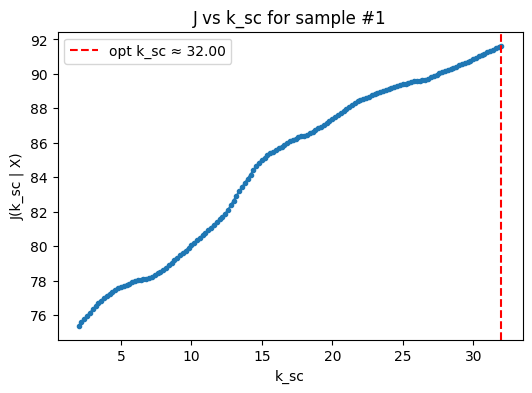

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

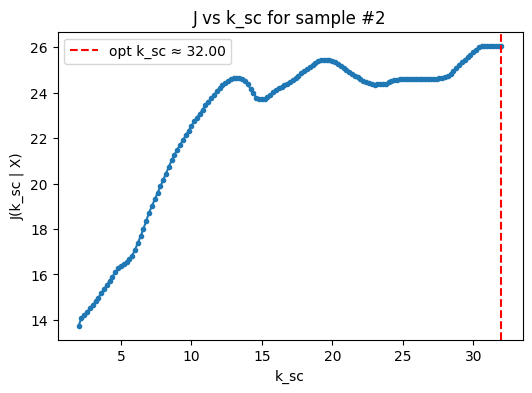

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

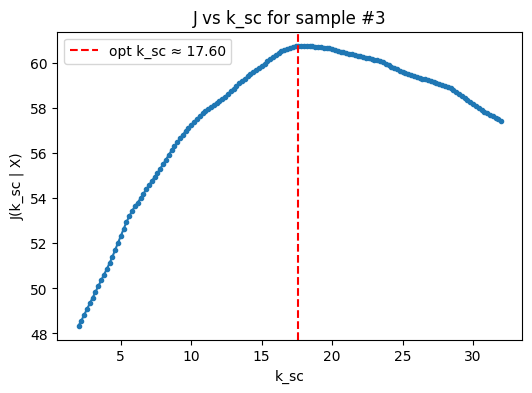

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from tensorflow import keras # Import keras to load the model

# ————————————————
# 1. Load models & scalers
# ————————————————
# Use keras.models.load_model to load the Keras model
surrogate = keras.models.load_model("surrogate_mlp_tf.keras")  # your MultiOutputRegressor
scaler_X   = joblib.load("scaler_X.pkl")        # feature StandardScaler
scaler_y   = joblib.load("scaler_y.pkl")        # target StandardScaler

# The 8 input columns (no k_sc) that your scaler_X expects:
input_cols_nok = [
    "Irradiance","AmbientTemp","rload","cload",
    "Inductor","Capacitor","Vpv_avg","Ipv_avg","dV","dP"
]

# ————————————————
# 2. Set weights
# ————————————————
alpha = 1.0
betas = np.ones(7)  # penalties for [Vpp, Vrms, Ipp, Irms, TimeDelay, deltaD, MPP(error)]

# ————————————————

# 3. Composite objective
# ————————————————
def J_of_ksc(X_raw, ksc_candidate):
    # X_raw: length-8 array matching input_cols_nok
    # Ensure the columns are in the same order as during fitting
    # Modified this part:
    df_row = pd.DataFrame([ {**dict(zip(input_cols_nok[:-2], X_raw[:-2])),
                             **dict(zip(input_cols_nok[-2:], X_raw[-2:])),
                             "k_sc": ksc_candidate} ])    # 'k_sc' is now last and dict is modified

    # scale inputs
    Xs = scaler_X.transform(df_row)
    # predict all 8 targets
    y_hat_s = surrogate.predict(Xs)
    # inverse-scale back to original units
    y_hat   = scaler_y.inverse_transform(y_hat_s).ravel()
    # eta is 6th entry, penalties are the other seven (in order)
    eta       = y_hat[5]
    penalties = np.concatenate([
        y_hat[0:4],       # ripples
        [y_hat[4]],       # TimeDelay
        [y_hat[6]],       # deltaD
        [y_hat[7]]        # MPP(error)
    ])
    return eta - alpha * np.dot(betas, penalties)
    # inverse-scale back to original units
    y_hat   = scaler_y.inverse_transform(y_hat_s).ravel()
    # eta is 6th entry, penalties are the other seven (in order)
    eta       = y_hat[5]
    penalties = np.concatenate([
        y_hat[0:4],       # ripples
        [y_hat[4]],       # TimeDelay
        [y_hat[6]],       # deltaD
        [y_hat[7]]        # MPP(error)
    ])
    return eta - alpha * np.dot(betas, penalties)

# ————————————————
# 4. Sanity-check plots
# ————————————————
X_val_nok = X_val[input_cols_nok].values

for i, X_sample in enumerate(X_val_nok[:3]):
    k_grid = np.linspace(2, 32, 151)
    J_vals = [J_of_ksc(X_sample, k) for k in k_grid]

    plt.figure(figsize=(6,4))
    plt.plot(k_grid, J_vals, '-o', markersize=3)
    best_k = k_grid[np.argmax(J_vals)]
    plt.axvline(best_k, color='r', linestyle='--',
                label=f"opt k_sc ≈ {best_k:.2f}")
    plt.title(f"J vs k_sc for sample #{i+1}")
    plt.xlabel("k_sc")
    plt.ylabel("J(k_sc | X)")
    plt.legend()
    plt.show()

In [10]:
import numpy as np
import pandas as pd
import joblib
from tensorflow import keras # Import keras to load the model

# 1.1 Load your trained surrogate and scalers
# Use keras.models.load_model to load the Keras model
surrogate = keras.models.load_model("surrogate_mlp_tf.keras")
scaler_X   = joblib.load("scaler_X.pkl")        # feature StandardScaler
scaler_y   = joblib.load("scaler_y.pkl")        # target StandardScaler

# 1.2 Prepare your validation inputs (drop k_sc)
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg","dV","dP"
]
X_val_nok = X_val[input_cols].values   # assumes X_val DataFrame is in memory


In [11]:
alpha = 1.0
betas = np.ones(7)  # one weight for each penalty term

def J_of_ksc(X_raw, ksc_candidate):
    # wrap into a DataFrame so scaler_X.transform() accepts it
    row = dict(zip(input_cols, X_raw))
    row["k_sc"] = ksc_candidate
    df_row = pd.DataFrame([row])

    # scale, predict, inverse-scale
    x_s = scaler_X.transform(df_row)
    y_s = surrogate.predict(x_s)
    y   = scaler_y.inverse_transform(y_s).ravel()
    # y = [Vpp, Vrms, Ipp, Irms, TimeDelay, Efficiency, deltaD, MPP(error)]

    eta      = y[5]
    penalties = np.r_[y[0:4], y[4], y[6], y[7]]
    return eta - alpha * (betas @ penalties)


In [12]:
print(J_of_ksc(X_val_nok[0], 10.0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
80.04946102719987


In [13]:
# candidate values from 2 to 32 (151 points)
k_grid = np.linspace(2, 32, 151)
print("k_grid:", k_grid[:5], "...", k_grid[-5:])


k_grid: [2.  2.2 2.4 2.6 2.8] ... [31.2 31.4 31.6 31.8 32. ]


In [14]:
opt_k_small = []
for X_sample in X_val_nok[:10]:
    J_vals = [J_of_ksc(X_sample, k) for k in k_grid]
    opt_k_small.append(k_grid[np.argmax(J_vals)])

print("First 10 optimal k_sc:", opt_k_small)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

In [15]:
import numpy as np
import pandas as pd
import joblib
from joblib import Parallel, delayed
from tensorflow import keras # Import keras to load the model

# ————————————————
# 1. Load full dataset
# ————————————————
df_full = pd.read_csv("/content/Final_Dataset10kfinalAttempt.csv")

# 2. Define your 8 inputs (no k_sc)
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg","dV","dP"
]
X_full = df_full[input_cols].values   # shape (10573, 8)

# ————————————————
# 3. Load surrogate & scalers
# ————————————————
# Use keras.models.load_model to load the Keras model
surrogate = keras.models.load_model("surrogate_mlp_tf.keras")  # your trained MultiOutputRegressor
scaler_X   = joblib.load("scaler_X.pkl")        # feature StandardScaler
scaler_y   = joblib.load("scaler_y.pkl")        # target StandardScaler

# ————————————————
# 4. Prepare integer-only k_sc grid
# ————————————————
k_grid = np.arange(2, 33, 1)  # integers 2,3,...,32

# ————————————————
# 5. Define your composite objective J
# ————————————————
alpha = 1.0
betas = np.ones(7)  # weights for [Vpp, Vrms, Ipp, Irms, TimeDelay, deltaD, MPP(error)]

def find_opt_k_vectorized(X_raw):
    """
    Vectorized search: for one 8-dim input X_raw, evaluate J over all k in k_grid
    and return the integer k_sc that maximizes J.
    """
    # build a DataFrame of shape (n_k, 9) with columns input_cols + ["k_sc"]
    df_rows = pd.DataFrame([
        {**dict(zip(input_cols, X_raw)), "k_sc": k}
        for k in k_grid
    ])
    # batch transform & predict
    Xs = scaler_X.transform(df_rows)
    Ys = surrogate.predict(Xs)                   # shape (n_k, 8)
    Ys_orig = scaler_y.inverse_transform(Ys)      # back to real-unit metrics

    # compute penalties and objectives
    ripples      = Ys_orig[:, 0:4].sum(axis=1)    # sum of the 4 ripple metrics
    time_delay   = Ys_orig[:, 4]
    efficiency   = Ys_orig[:, 5]
    delta_d      = Ys_orig[:, 6]
    mpp_error    = Ys_orig[:, 7]
    penalties    = ripples + time_delay + delta_d + mpp_error
    objectives   = efficiency - alpha * penalties

    # pick the k_sc with max objective
    best_idx = np.argmax(objectives)
    return int(k_grid[best_idx])

# ————————————————
# 6. Run over the full dataset in parallel
# ————————————————
# This will use all available CPU cores (set n_jobs to your preferred value)
opt_k_full = Parallel(n_jobs=-1, verbose=5)(
    delayed(find_opt_k_vectorized)(X_full[i])
    for i in range(len(X_full))
)

# ————————————————
# 7. Assemble & save the results
# ————————————————
out_df = df_full[input_cols].copy()
out_df["k_sc_opt"] = opt_k_full
out_df.to_csv("k_sc_opt_full_dataset.csv", index=False)

print(f"Saved {len(out_df)} optimal k_sc values to 'k_sc_opt_full_dataset.csv'")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   24.5s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 2174 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 3038 tasks      | elapsed: 10.5min
/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker sto

Saved 10573 optimal k_sc values to 'k_sc_opt_full_dataset.csv'


[Parallel(n_jobs=-1)]: Done 10573 out of 10573 | elapsed: 36.8min finished


In [16]:
# Phase 5a – Baseline Random Forest for direct k_sc prediction (percentage metrics)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import joblib

# 1. Load your full mapping of features → optimal k_sc
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg", "dV", "dP"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation sets (85% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Train a baseline Random Forest
rf_base = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
rf_base.fit(X_train, y_train)
joblib.dump(rf_base, "direct_rf_baseline.pkl")

# 4. Predict on validation set
y_pred = rf_base.predict(X_val)

# 5. Compute metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae  = mean_absolute_error(y_val, y_pred)
mean_k = np.mean(y_val)
rmse_pct = (rmse / mean_k) * 100
mae_pct  = (mae  / mean_k) * 100
mape_pct = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

# NEW: R² score
r2 = r2_score(y_val, y_pred)

# 6. Display results
print("RF baseline performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")
print(f"  R² score    = {r2:.3f}")


RF baseline performance on validation (percentages):
  RMSE%       = 15.67%
  MAE%        = 6.96%
  MAPE%       = 11.91%
  % within ±1 = 67.5%
  R² score    = 0.869


In [17]:
# Phase 5b – Hyperparameter‐Tuned Random Forest

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import joblib

# 1. Load data
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = ["Irradiance","AmbientTemp","rload","cload","Inductor","Capacitor","Vpv_avg","Ipv_avg","dV","dP"]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. GridSearch over RF hyperparameters
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth":    [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}
grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_train, y_train)

# 4. Save best model
rf_tuned = grid_rf.best_estimator_
joblib.dump(rf_tuned, "direct_rf_tuned.pkl")
print("Best RF params:", grid_rf.best_params_)

# 5. Evaluate on validation set (percentage metrics)
y_pred = rf_tuned.predict(X_val)
mean_k     = np.mean(y_val)
rmse_pct   = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct    = mean_absolute_error(y_val, y_pred) / mean_k * 100
mape_pct   = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

# 6. Compute R²
r2 = r2_score(y_val, y_pred)

print("\nTuned RF performance:")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")
print(f"  R² score    = {r2:.3f}")


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best RF params: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}

Tuned RF performance:
  RMSE%       = 15.64%
  MAE%        = 6.97%
  MAPE%       = 11.90%
  % within ±1 = 67.7%
  R² score    = 0.870


In [18]:
rmse_frac = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k
print(f"RMSE fraction = {rmse_frac:.3f}")  # e.g. 0.199


RMSE fraction = 0.156


In [20]:
# Phase 5c – Baseline XGBoost for direct k_sc prediction (percentage metrics)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import xgboost as xgb
import joblib

# 1. Load your full mapping of features → optimal k_sc
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg","dV","dP"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation sets (85% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Train a baseline XGBoost regressor
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

# 4. Save the model
joblib.dump(xgb_model, "direct_xgb_baseline.pkl")

# 5. Predict on validation set
y_pred = xgb_model.predict(X_val)

# 6. Compute percentage‐based metrics
mean_k      = np.mean(y_val)
rmse_pct    = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct     = mean_absolute_error(y_val, y_pred) / mean_k * 100
mape_pct    = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

# NEW: Compute R²
r2 = r2_score(y_val, y_pred)

# 7. Display results
print("XGBoost baseline performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")
print(f"  R² score    = {r2:.3f}")


XGBoost baseline performance on validation (percentages):
  RMSE%       = 17.26%
  MAE%        = 10.21%
  MAPE%       = 17.56%
  % within ±1 = 48.4%
  R² score    = 0.841


In [21]:
# Phase 5d – Hyperparameter-Tuned XGBoost for direct k_sc prediction
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import xgboost as xgb

# 1. Load the full mapping of features → optimal k_sc
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg", "dV", "dP"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation sets (85% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Set up GridSearch over XGBoost hyperparameters
param_grid = {
    "n_estimators":  [100, 300, 500],
    "max_depth":     [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample":     [0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(
    random_state=42,
    n_jobs=-1,
    objective="reg:squarederror"
)

grid_xgb = GridSearchCV(
    xgb_model,
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

# 4. Run the search
grid_xgb.fit(X_train, y_train)

# 5. Save the best model
xgb_tuned = grid_xgb.best_estimator_
joblib.dump(xgb_tuned, "direct_xgb_tuned.pkl")
print("Best XGB params:", grid_xgb.best_params_)

# 6. Evaluate on validation set (percentage metrics)
y_pred = xgb_tuned.predict(X_val)
mean_k     = np.mean(y_val)
rmse_pct   = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct    = mean_absolute_error(y_val, y_pred) / mean_k * 100
mape_pct   = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

# 7. Compute R²
r2 = r2_score(y_val, y_pred)

print("\nTuned XGBoost performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")
print(f"  R² score    = {r2:.3f}")


Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGB params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}

Tuned XGBoost performance on validation (percentages):
  RMSE%       = 15.51%
  MAE%        = 7.39%
  MAPE%       = 12.20%
  % within ±1 = 62.9%
  R² score    = 0.872


In [22]:
# Phase 5e – Baseline LightGBM for direct k_sc prediction (percentage metrics)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from lightgbm import LGBMRegressor
import joblib

# 1. Load your full mapping of features → optimal k_sc
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg", "dV", "dP"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation sets (85% train, 15% val)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Train a baseline LightGBM regressor
lgb_model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42,
    n_jobs=-1
)
lgb_model.fit(X_train, y_train)

# 4. Save the model
joblib.dump(lgb_model, "direct_lgb_baseline.pkl")

# 5. Predict on validation set
y_pred = lgb_model.predict(X_val)

# 6. Compute percentage‐based metrics
mean_k      = np.mean(y_val)
rmse_pct    = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct     = mean_absolute_error(y_val, y_pred) / mean_k * 100
mape_pct    = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

# 7. Compute R²
r2 = r2_score(y_val, y_pred)

# 8. Display results
print("LightGBM baseline performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")
print(f"  R² score    = {r2:.3f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 8987, number of used features: 10
[LightGBM] [Info] Start training from score 21.853344
LightGBM baseline performance on validation (percentages):
  RMSE%       = 17.24%
  MAE%        = 10.32%
  MAPE%       = 18.01%
  % within ±1 = 47.7%
  R² score    = 0.842


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [23]:
#lightgb tuned
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from lightgbm import LGBMRegressor
import joblib

# 1. Reload data & split (as before)
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance","AmbientTemp","rload","cload",
    "Inductor","Capacitor","Vpv_avg","Ipv_avg","dV","dP"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 2. Define a smaller hyper-parameter space
param_dist = {
    "n_estimators":  [100, 300, 500],
    "max_depth":     [-1, 10, 20],
    "learning_rate": [0.01, 0.05, 0.1],
    "num_leaves":    [31, 63, 127]
}

lgb = LGBMRegressor(random_state=42, n_jobs=-1)
rand_lgb = RandomizedSearchCV(
    lgb,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rand_lgb.fit(X_train, y_train)
lgb_tuned = rand_lgb.best_estimator_
joblib.dump(lgb_tuned, "direct_lgb_randsearch.pkl")
print("Best rand-LGB params:", rand_lgb.best_params_)

# 3. Quick validation
y_pred = lgb_tuned.predict(X_val)
mean_k     = np.mean(y_val)
rmse_pct   = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct    = mean_absolute_error(y_val, y_pred) / mean_k * 100
mape_pct   = mean_absolute_percentage_error(y_val, y_pred) * 100
pct1       = np.mean(np.abs(y_pred - y_val) <= 1) * 100
r2         = r2_score(y_val, y_pred)

print(
    f"Rand-LGB performance: RMSE%={rmse_pct:.2f}%  "
    f"MAE%={mae_pct:.2f}%  MAPE%={mape_pct:.2f}%  "
    f"%±1={pct1:.1f}%  R²={r2:.3f}"
)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 8987, number of used features: 10
[LightGBM] [Info] Start training from score 21.853344
Best rand-LGB params: {'num_leaves': 127, 'n_estimators': 500, 'max_depth': -1, 'learning_rate': 0.05}
Rand-LGB performance: RMSE%=16.11%  MAE%=8.51%  MAPE%=14.85%  %±1=56.7%  R²=0.862


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [24]:
# Phase 5h – Upgraded Keras MLP for direct k_sc prediction
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Load data
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance", "AmbientTemp", "rload", "cload",
    "Inductor",   "Capacitor", "Vpv_avg", "Ipv_avg","dV","dP"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Scale inputs
scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)

# 4. Build a deeper MLP with BatchNorm & Dropout
inp = Input(shape=(X_train_scaled.shape[1],))
x = Dense(256, activation="relu")(inp)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(128, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Dense(64, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

out = Dense(1, activation="linear")(x)

model = Model(inputs=inp, outputs=out)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# 5. Callbacks for early stopping and LR reduction
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5)

# 6. Train
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[es, rlr],
    verbose=2
)

# 7. Evaluate on validation set (percentage metrics + R²)
y_pred = model.predict(X_val_scaled).ravel()
mean_k     = np.mean(y_val)
rmse_pct   = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct    = mean_absolute_error(y_val, y_pred) / mean_k * 100
mape_pct   = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1= np.mean(np.abs(y_pred - y_val) <= 1) * 100
r2         = r2_score(y_val, y_pred)

print("Upgraded MLP performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")
print(f"  R² score    = {r2:.3f}")

# 8. Save model & scaler
model.save("direct_mlp_upgraded.h5")
joblib.dump(scaler_X, "scaler_X_direct_mlp.pkl")


Epoch 1/100
141/141 - 7s - 49ms/step - loss: 498.1687 - root_mean_squared_error: 22.3197 - val_loss: 551.2183 - val_root_mean_squared_error: 23.4780 - learning_rate: 1.0000e-03
Epoch 2/100
141/141 - 2s - 16ms/step - loss: 328.2272 - root_mean_squared_error: 18.1170 - val_loss: 266.7920 - val_root_mean_squared_error: 16.3338 - learning_rate: 1.0000e-03
Epoch 3/100
141/141 - 1s - 9ms/step - loss: 132.2657 - root_mean_squared_error: 11.5007 - val_loss: 56.5305 - val_root_mean_squared_error: 7.5187 - learning_rate: 1.0000e-03
Epoch 4/100
141/141 - 1s - 8ms/step - loss: 52.1761 - root_mean_squared_error: 7.2233 - val_loss: 26.5991 - val_root_mean_squared_error: 5.1574 - learning_rate: 1.0000e-03
Epoch 5/100
141/141 - 1s - 8ms/step - loss: 39.7206 - root_mean_squared_error: 6.3024 - val_loss: 25.7707 - val_root_mean_squared_error: 5.0765 - learning_rate: 1.0000e-03
Epoch 6/100
141/141 - 1s - 10ms/step - loss: 38.5060 - root_mean_squared_error: 6.2053 - val_loss: 22.4514 - val_root_mean_squar

Upgraded MLP performance on validation (percentages):
  RMSE%       = 16.74%
  MAE%        = 9.80%
  MAPE%       = 16.98%
  % within ±1 = 46.4%
  R² score    = 0.851


['scaler_X_direct_mlp.pkl']

In [25]:
# Phase 5h(3) – Hyperparameter Tuning of the Residual MLP with Keras Tuner
!pip install keras-tuner -q
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score           # << add this
)

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Add, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

# 1. Load & split
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = ["Irradiance","AmbientTemp","rload","cload","Inductor","Capacitor","Vpv_avg","Ipv_avg","dV","dP"]
X = df[input_cols].values
y = df["k_sc_opt"].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

# 2. Scale inputs
scaler_X = StandardScaler().fit(X_train)
X_train_s = scaler_X.transform(X_train)
X_val_s   = scaler_X.transform(X_val)

# 3. Build tuner model function
def build_residual_mlp(hp):
    inp = Input(shape=(X_train_s.shape[1],))
    x = inp
    # first dense block
    x = Dense(
        units=hp.Int("first_units", 128, 512, step=64),
        kernel_regularizer=l2(hp.Float("l2_reg", 1e-5, 1e-3, sampling="log"))
    )(x)
    x = BatchNormalization()(x)
    x = Activation(hp.Choice("first_act", ["relu", "swish"]))(x)
    x = Dropout(hp.Float("first_drop", 0.2, 0.5, step=0.1))(x)

    # variable number of residual blocks
    for i in range(hp.Int("n_res_blocks", 1, 3)):
        res = Dense(
            units=hp.Int(f"res_units_{i}", 128, 512, step=64),
            kernel_regularizer=l2(hp.Float(f"l2_reg_{i}", 1e-5, 1e-3, sampling="log"))
        )(x)
        res = BatchNormalization()(res)
        res = Activation(hp.Choice(f"res_act_{i}", ["relu", "swish"]))(res)
        res = Dropout(hp.Float(f"res_drop_{i}", 0.2, 0.5, step=0.1))(res)
        res = Dense(
            units=x.shape[-1],
            kernel_regularizer=l2(hp.Float(f"l2_reg2_{i}", 1e-5, 1e-3, sampling="log"))
        )(res)
        res = BatchNormalization()(res)
        x = Add()([x, res])
        x = Activation(hp.Choice(f"res_out_act_{i}", ["relu", "swish"]))(x)

    # output block
    x = Dense(
        units=hp.Int("final_units", 64, 256, step=64),
        activation=hp.Choice("final_act", ["relu", "swish"]),
        kernel_regularizer=l2(hp.Float("l2_reg_final", 1e-5, 1e-3, sampling="log"))
    )(x)
    x = Dropout(hp.Float("final_drop", 0.1, 0.3, step=0.1))(x)
    out = Dense(1, activation="linear")(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(hp.Float("lr", 1e-4, 1e-2, sampling="log")),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

# 4. Set up Hyperband tuner
tuner = kt.Hyperband(
    build_residual_mlp,
    objective="val_root_mean_squared_error",
    max_epochs=50,
    factor=3,
    directory="res_mlp_tuner",
    project_name="direct_residual_mlp"
)

# 5. Early stopping callback
stop_early = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# 6. Run tuner search
tuner.search(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    callbacks=[stop_early],
    verbose=1
)

# 7. Retrieve best model and evaluate
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hp)
best_model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=50,
    callbacks=[stop_early],
    verbose=1
)
# 8. Evaluate on validation set
y_pred = best_model.predict(X_val_s).ravel()
mean_k     = np.mean(y_val)
rmse_pct   = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct    = mean_absolute_error(y_val, y_pred) / mean_k * 100
mape_pct   = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1= np.mean(np.abs(y_pred - y_val) <= 1) * 100

# ----- NEW: compute R² -----
r2 = r2_score(y_val, y_pred)

print("Tuned Residual MLP performance (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")
print(f"  R² score    = {r2:.3f}")   # << and this

Reloading Tuner from res_mlp_tuner/direct_residual_mlp/tuner0.json
Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 80.1650 - root_mean_squared_error: 8.7642 - val_loss: 60.9577 - val_root_mean_squared_error: 7.7819
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 47.7053 - root_mean_squared_error: 6.8759 - val_loss: 32.1361 - val_root_mean_squared_error: 5.6298
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 40.3072 - root_mean_squared_error: 6.3122 - val_loss: 28.1506 - val_root_mean_squared_error: 5.2598
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 40.1081 - root_mean_squared_error: 6.2933 - val_loss: 31.5324 - val_root_mean_squared_error: 5.5679
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 39.8928 - root_mean_squared_error: 6.2720 - val_loss: 26.0806 - val_root_mean_squared_error: 5.0500
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 37.5439 - root_mean_squared_error: 6.0769 - val_loss: 26.7008 - val

In [26]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score               # ← add this
)

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt
import joblib

# 1. Load & split data
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = ["Irradiance","AmbientTemp","rload","cload",
              "Inductor","Capacitor","Vpv_avg","Ipv_avg","dV","dP"]
X = df[input_cols].values
y = df["k_sc_opt"].values
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 2. Scale inputs
scaler_X = StandardScaler().fit(X_train)
X_train_s = scaler_X.transform(X_train)
X_val_s   = scaler_X.transform(X_val)

# 3. Define tunable MLP builder
def build_small_mlp(hp):
    inp = Input(shape=(X_train_s.shape[1],))
    x = inp
    # only 1–2 dense layers, 64–256 units
    for i in range(hp.Int("layers", 1, 2)):
        x = Dense(
            units=hp.Int(f"units_{i}", 64, 256, step=64),
            activation="swish"
        )(x)
        x = Dropout(hp.Float(f"drop_{i}", 0.1, 0.3, step=0.1))(x)
    out = Dense(1, activation="linear")(x)
    model = Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=Adam(hp.Float("lr", 1e-4, 1e-3, sampling="log")),
        loss="mse",
        metrics=["root_mean_squared_error"]
    )
    return model

# 4. Set up Hyperband tuner optimizing validation loss
tuner = kt.Hyperband(
    build_small_mlp,
    objective="val_loss",
    max_epochs=20,
    factor=2,
    directory="fast_mlp_tuner",
    project_name="direct_mlp_fast"
)

stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# 5. Run tuner search
tuner.search(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    callbacks=[stop],
    verbose=1
)

# 6. Retrieve best model and fine-tune
best_model = tuner.get_best_models(num_models=1)[0]
best_model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=20,
    callbacks=[stop],
    verbose=1
)

# 7. Evaluate performance on validation set
y_pred = best_model.predict(X_val_s).ravel()
mean_k      = np.mean(y_val)
rmse_pct    = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct     = mean_absolute_error(y_val, y_pred) / mean_k * 100
mape_pct    = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100

# ← NEW: compute R²
r2 = r2_score(y_val, y_pred)

print("Fast MLP Tuned performance (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")
print(f"  R² score    = {r2:.3f}")   # ← and this

# 8. Save best model & scaler
best_model.save("direct_mlp_fast_tuned.h5")
joblib.dump(scaler_X, "scaler_X_direct_mlp_fast.pkl")


Trial 92 Complete [00h 00m 25s]
val_loss: 57.08443069458008

Best val_loss So Far: 29.139949798583984
Total elapsed time: 00h 15m 23s
Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 32.9621 - root_mean_squared_error: 5.7405 - val_loss: 27.9039 - val_root_mean_squared_error: 5.2824
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 31.5279 - root_mean_squared_error: 5.6143 - val_loss: 27.2042 - val_root_mean_squared_error: 5.2158
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 30.4496 - root_mean_squared_error: 5.5147 - val_loss: 27.2116 - val_root_mean_squared_error: 5.2165
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 31.6162 - root_mean_squared_error: 5.6221 - val_loss: 26.8107 - val_root_mean_squared_error: 5.1779
Epoch 5/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 30.1921 - root_mean_squared_error: 5.4942 - val_loss: 26.6365 - val_root_mean_squared_error: 5.1611
Epoch 6/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 29.241

Fast MLP Tuned performance (percentages):
  RMSE%       = 21.73%
  MAE%        = 15.47%
  MAPE%       = 27.27%
  % within ±1 = 26.4%
  R² score    = 0.749


['scaler_X_direct_mlp_fast.pkl']

In [27]:
import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# 1. Load data
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance","AmbientTemp","rload","cload",
    "Inductor","Capacitor","Vpv_avg","Ipv_avg","dV","dP"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into train / validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Load your tuned models
rf_tuned  = joblib.load("direct_rf_tuned.pkl")
xgb_tuned = joblib.load("direct_xgb_tuned.pkl")

# 4. Build the ensemble
ensemble = VotingRegressor(
    estimators=[('rf', rf_tuned), ('xgb', xgb_tuned)],
    n_jobs=-1
)
ensemble.fit(X_train, y_train)

# 5. Predict & compute metrics
y_pred = ensemble.predict(X_val)
mean_k     = np.mean(y_val)
rmse_pct   = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct    = mean_absolute_error(y_val, y_pred) / mean_k * 100
mape_pct   = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100
r2         = r2_score(y_val, y_pred)

print("RF+XGB Ensemble performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")
print(f"  R² score    = {r2:.3f}")

# 6. Save the ensemble model
joblib.dump(ensemble, "ensemble_rf_xgb.pkl")


RF+XGB Ensemble performance on validation (percentages):
  RMSE%       = 15.38%
  MAE%        = 7.01%
  MAPE%       = 11.80%
  % within ±1 = 66.1%
  R² score    = 0.874


['ensemble_rf_xgb.pkl']

In [30]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

# 1. Load data & split
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance","AmbientTemp","rload","cload",
    "Inductor","Capacitor","Vpv_avg","Ipv_avg","dV","dP"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 2. Load your tuned RF & XGB models
rf_tuned  = joblib.load("direct_rf_tuned.pkl")
xgb_tuned = joblib.load("direct_xgb_tuned.pkl")

# 3. Load and recompile your tuned MLP model without errors
mlp_model = tf.keras.models.load_model(
    "direct_mlp_upgraded.h5",
    compile=False
)
mlp_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[RootMeanSquaredError()]
)

# 4. Scale features for the MLP
scaler = joblib.load("scaler_X_direct_mlp.pkl")
X_val_scaled = scaler.transform(X_val)

# 5. Make predictions
y_rf  = rf_tuned.predict(X_val)
y_xgb = xgb_tuned.predict(X_val)
y_mlp = mlp_model.predict(X_val_scaled).ravel()

# 6. Ensemble by simple averaging
y_pred = (y_rf + y_xgb + y_mlp) / 3.0

# 7. Compute performance metrics
mean_k      = np.mean(y_val)
rmse_pct    = np.sqrt(mean_squared_error(y_val, y_pred)) / mean_k * 100
mae_pct     = mean_absolute_error(y_val, y_pred) / mean_k * 100
mape_pct    = mean_absolute_percentage_error(y_val, y_pred) * 100
pct_within1 = np.mean(np.abs(y_pred - y_val) <= 1) * 100
r2          = r2_score(y_val, y_pred)

# 8. Display results
print("Ensemble (RF + XGB + MLP) performance on validation (percentages):")
print(f"  RMSE%       = {rmse_pct:.2f}%")
print(f"  MAE%        = {mae_pct:.2f}%")
print(f"  MAPE%       = {mape_pct:.2f}%")
print(f"  % within ±1 = {pct_within1:.1f}%")
print(f"  R² score    = {r2:.3f}")

# 9. (Optional) Save the ensemble predictions or model
joblib.dump(y_pred, "ensemble_preds.npy")


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Ensemble (RF + XGB + MLP) performance on validation (percentages):
  RMSE%       = 14.93%
  MAE%        = 7.50%
  MAPE%       = 12.84%
  % within ±1 = 62.0%
  R² score    = 0.881


['ensemble_preds.npy']

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
import joblib
import tensorflow as tf
from tensorflow.keras.models import load_model

# 1. Load dataset
df = pd.read_csv("k_sc_opt_full_dataset.csv")
input_cols = [
    "Irradiance","AmbientTemp","rload","cload",
    "Inductor","Capacitor","Vpv_avg","Ipv_avg","dV","dP"
]
X = df[input_cols].values
y = df["k_sc_opt"].values

# 2. Split into (train+val) and test
X_trval, X_test, y_trval, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# precompute mean of true k_sc for percentage metrics
mean_k = np.mean(y_test)

# 3. Load your models
ensemble1 = joblib.load("/content/ensemble_rf_xgb.pkl")
ensemble2 = joblib.load("/content/ensemble_preds.npy") # predictions array
rf_model  = joblib.load("/content/direct_rf_tuned.pkl")
xgb_model = joblib.load("/content/direct_xgb_tuned.pkl")
lgb_model = joblib.load("/content/direct_lgb_randsearch.pkl")

# 4. Load MLP and its scaler
mlp_scaler = joblib.load("/content/scaler_X_direct_mlp.pkl")
mlp_model  = load_model("/content/direct_mlp_upgraded.h5", compile=False)

# 5. Prepare models dict
models = {
    "Ensemble #1":    ensemble1,
    "Ensemble #2":    ensemble2,
    "RF Tuned":       rf_model,
    "XGB Tuned":      xgb_model,
    "LGB RandSearch": lgb_model,
    "MLP Upgraded":   mlp_model
}

# 6. Evaluate each on the test set
results = []
for name, model in models.items():
    if name == "MLP Upgraded":
        X_in = mlp_scaler.transform(X_test)
        y_pred = model.predict(X_in).ravel()
    elif name == "Ensemble #2":
        y_pred = model  # already a numpy array of predictions
    else:
        y_pred = model.predict(X_test)

    # absolute errors
    rmse_abs = np.sqrt(mean_squared_error(y_test, y_pred))
    mae_abs  = mean_absolute_error(y_test, y_pred)

    # percentage errors
    rmse_pct = (rmse_abs / mean_k) * 100
    mae_pct  = (mae_abs  / mean_k) * 100
    mape_pct = mean_absolute_percentage_error(y_test, y_pred) * 100
    r2       = r2_score(y_test, y_pred)

    results.append({
        "Model":  name,
        "R²":     f"{r2:.3f}",
        "RMSE%":  f"{rmse_pct:.2f}%",
        "MAE%":   f"{mae_pct:.2f}%",
        "MAPE%":  f"{mape_pct:.2f}%"
    })

# 7. Display results
df_results = pd.DataFrame(results, columns=["Model","R²","RMSE%","MAE%","MAPE%"])
print("\nTest-set Performance Comparison:")
print(df_results.to_string(index=False))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Test-set Performance Comparison:
         Model    R²  RMSE%  MAE%  MAPE%
   Ensemble #1 0.874 15.38% 7.01% 11.80%
   Ensemble #2 0.881 14.93% 7.50% 12.84%
      RF Tuned 0.870 15.64% 6.97% 11.90%
     XGB Tuned 0.872 15.51% 7.39% 12.20%
LGB RandSearch 0.862 16.11% 8.51% 14.85%
  MLP Upgraded 0.851 16.74% 9.80% 16.98%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


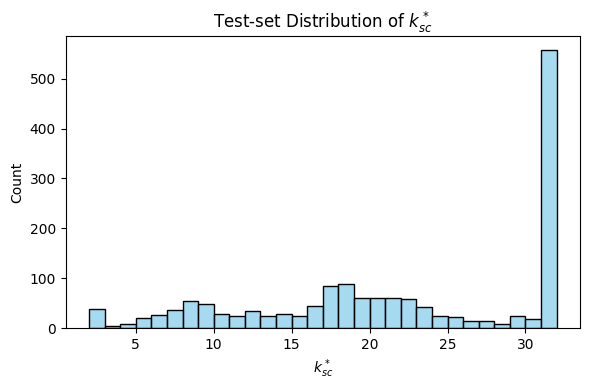

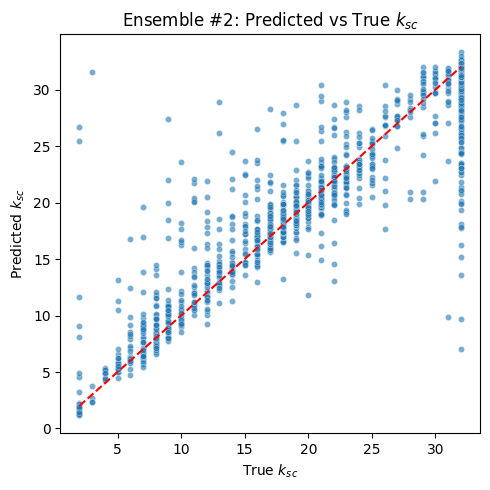

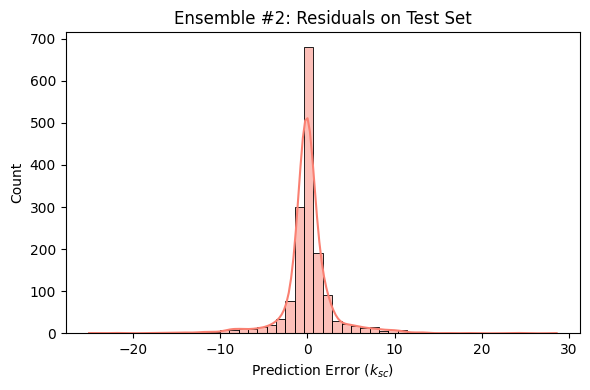

         Model       R²     RMSE%     MAE%     MAPE%
   Ensemble #1 0.874017 15.380109 7.011317 11.804655
   Ensemble #2 0.881256 14.931729 7.501708 12.838786
      RF Tuned 0.869701 15.641328 6.970301 11.903936
     XGB Tuned 0.871824 15.513377 7.391101 12.202667
LGB RandSearch 0.861810 16.108025 8.507089 14.848739
  MLP Upgraded 0.850690 16.743589 9.804618 16.976792


<ipython-input-41-ecd27be0045b>:90: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE%", data=perf_df, ax=axes[0], palette="viridis")
<ipython-input-41-ecd27be0045b>:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="MAPE%", data=perf_df, ax=axes[1], palette="magma")
<ipython-input-41-ecd27be0045b>:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
<ipython-input-41-ecd27be0045b>:97: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.s

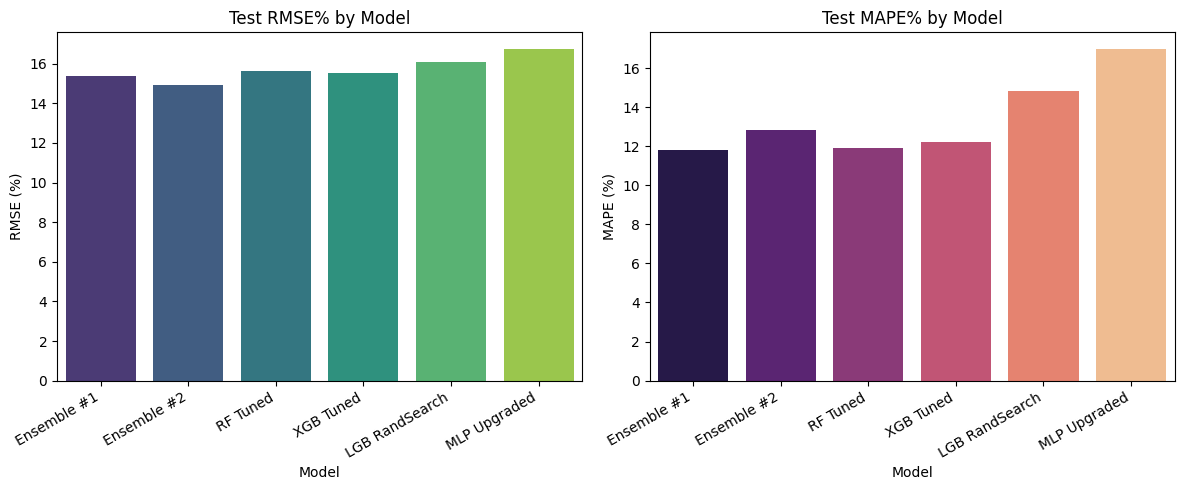

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.preprocessing import StandardScaler

# 1. Load dataset and split
df = pd.read_csv("k_sc_opt_full_dataset.csv")
features = ["Irradiance","AmbientTemp","rload","cload",
            "Inductor","Capacitor","Vpv_avg","Ipv_avg","dV","dP"]
X = df[features].values
y = df["k_sc_opt"].values
_, X_test, _, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# 2. Load models & scaler for MLP
ensemble1 = joblib.load("/content/ensemble_rf_xgb.pkl")
ensemble2_preds = joblib.load("/content/ensemble_preds.npy")
rf_model  = joblib.load("/content/direct_rf_tuned.pkl")
xgb_model = joblib.load("/content/direct_xgb_tuned.pkl")
lgb_model = joblib.load("/content/direct_lgb_randsearch.pkl")
mlp_scaler = joblib.load("/content/scaler_X_direct_mlp.pkl")
mlp_model  = load_model("/content/direct_mlp_upgraded.h5", compile=False)

# 3. Generate predictions
preds = {
    "Ensemble #1":   ensemble1.predict(X_test),
    "Ensemble #2":   ensemble2_preds,
    "RF Tuned":      rf_model.predict(X_test),
    "XGB Tuned":     xgb_model.predict(X_test),
    "LGB RandSearch":lgb_model.predict(X_test),
    "MLP Upgraded":  mlp_model.predict(mlp_scaler.transform(X_test)).ravel()
}

# 4. Plot: Distribution of optimal k_sc in test set
plt.figure(figsize=(6,4))
sns.histplot(y_test, bins=30, kde=False, color="skyblue")
plt.title("Test-set Distribution of $k_{sc}^*$")
plt.xlabel("$k_{sc}^*$"); plt.ylabel("Count")
plt.tight_layout()
plt.savefig("fig_hist_k_sc_test.png")
plt.show()

# 5. Plot: Predicted vs True for best model (e.g., Ensemble #2)
best = "Ensemble #2"
y_pred = preds[best]
plt.figure(figsize=(5,5))
sns.scatterplot(x=y_test, y=y_pred, s=20, alpha=0.6)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--')
plt.title(f"{best}: Predicted vs True $k_{{sc}}$")
plt.xlabel("True $k_{sc}$"); plt.ylabel("Predicted $k_{sc}$")
plt.tight_layout()
plt.savefig("fig_pred_vs_true.png")
plt.show()

# 6. Plot: Residual histogram for best model
res = y_pred - y_test
plt.figure(figsize=(6,4))
sns.histplot(res, bins=50, kde=True, color="salmon")
plt.title(f"{best}: Residuals on Test Set")
plt.xlabel("Prediction Error ($k_{sc}$)"); plt.ylabel("Count")
plt.tight_layout()
plt.savefig("fig_residuals.png")
plt.show()

# 7. Table & Bar plots: Performance metrics (no ±1%)
metrics = []
mean_k = y_test.mean()
for name, yhat in preds.items():
    rmse_pct = np.sqrt(mean_squared_error(y_test, yhat)) / mean_k * 100
    mae_pct  = mean_absolute_error(y_test, yhat) / mean_k * 100
    mape_pct = mean_absolute_percentage_error(y_test, yhat) * 100
    r2       = r2_score(y_test, yhat)
    metrics.append([name, r2, rmse_pct, mae_pct, mape_pct])

perf_df = pd.DataFrame(metrics, columns=["Model","R²","RMSE%","MAE%","MAPE%"])
print(perf_df.to_string(index=False))

# 8. Bar chart: RMSE% and MAPE% comparison
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.barplot(x="Model", y="RMSE%", data=perf_df, ax=axes[0], palette="viridis")
axes[0].set_title("Test RMSE% by Model")
axes[0].set_ylabel("RMSE (%)")
sns.barplot(x="Model", y="MAPE%", data=perf_df, ax=axes[1], palette="magma")
axes[1].set_title("Test MAPE% by Model")
axes[1].set_ylabel("MAPE (%)")
for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
plt.tight_layout()
plt.savefig("fig_model_comparison.png")
plt.show()



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


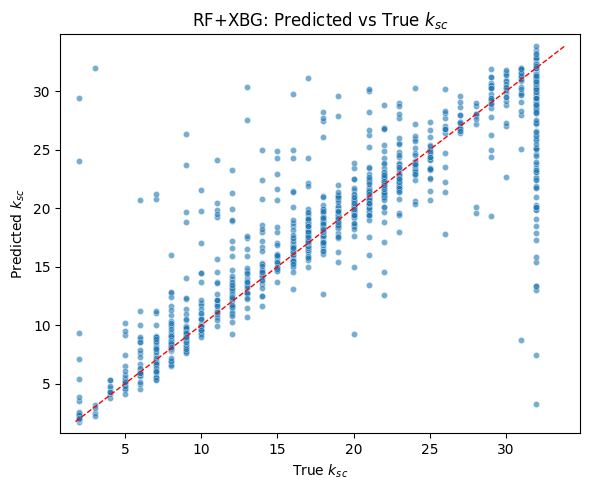

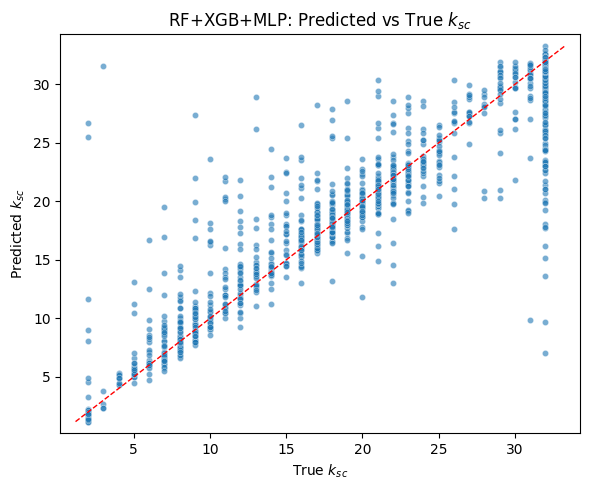

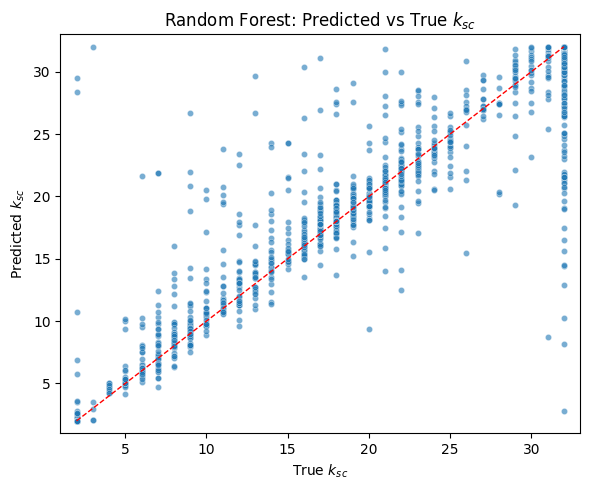

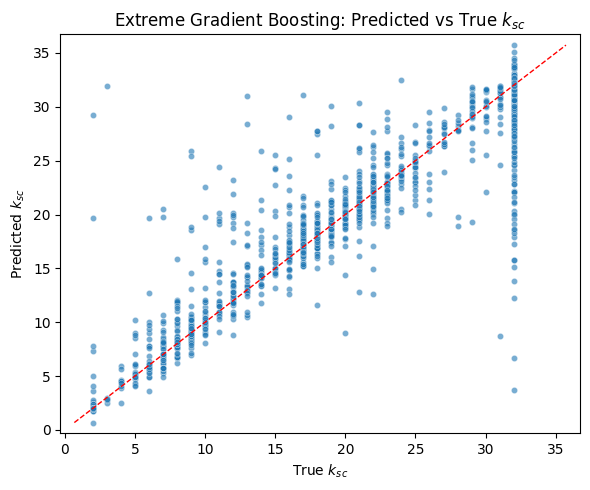

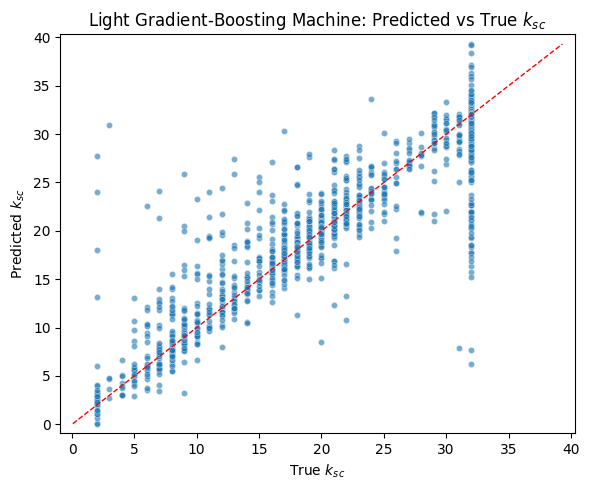

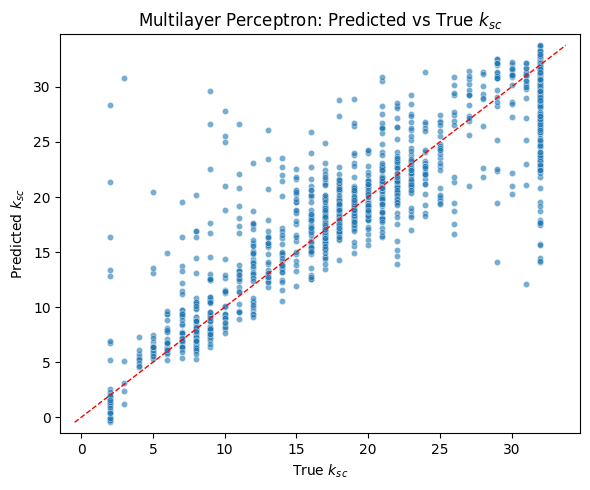

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Load data & split
df = pd.read_csv("k_sc_opt_full_dataset.csv")
features = ["Irradiance","AmbientTemp","rload","cload",
            "Inductor","Capacitor","Vpv_avg","Ipv_avg","dV","dP"]
X = df[features].values
y = df["k_sc_opt"].values
_, X_test, _, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# 2. Load models & scaler
ensemble1    = joblib.load("/content/ensemble_rf_xgb.pkl")
ensemble2_preds = joblib.load("/content/ensemble_preds.npy")
rf_model     = joblib.load("/content/direct_rf_tuned.pkl")
xgb_model    = joblib.load("/content/direct_xgb_tuned.pkl")
lgb_model    = joblib.load("/content/direct_lgb_randsearch.pkl")
mlp_scaler   = joblib.load("/content/scaler_X_direct_mlp.pkl")
mlp_model    = load_model("/content/direct_mlp_upgraded.h5", compile=False)

# 3. Prepare dict of predictions
preds = {
    "RF+XBG":   ensemble1.predict(X_test),
    "RF+XGB+MLP":   ensemble2_preds,
    "Random Forest":      rf_model.predict(X_test),
    "Extreme Gradient Boosting":     xgb_model.predict(X_test),
    "Light Gradient-Boosting Machine":lgb_model.predict(X_test),
    "Multilayer Perceptron":  mlp_model.predict(mlp_scaler.transform(X_test)).ravel()
}

# 4. Loop & plot
for name, y_pred in preds.items():
    plt.figure(figsize=(6,5))
    sns.scatterplot(x=y_test, y=y_pred, s=20, alpha=0.6)
    mn, mx = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
    plt.title(f"{name}: Predicted vs True $k_{{sc}}$")
    plt.xlabel("True $k_{sc}$")
    plt.ylabel("Predicted $k_{sc}$")
    plt.xlim(mn - 1, mx + 1)
    plt.ylim(mn - 1, mx + 1)
    plt.tight_layout()
    plt.savefig(f"fig_pred_vs_true_{name.replace(' ', '_')}.png", dpi=300)
    plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<ipython-input-45-40c812cac0c5>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R2", data=perf_df, ax=axes[0,0], palette="muted")
<ipython-input-45-40c812cac0c5>:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=30, ha="right")
<ipython-input-45-40c812cac0c5>:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE (%)", data=perf_df, ax=axes[0,1], palette="Blues_d")
<ipython-input-45-40c812cac0c5>:74: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

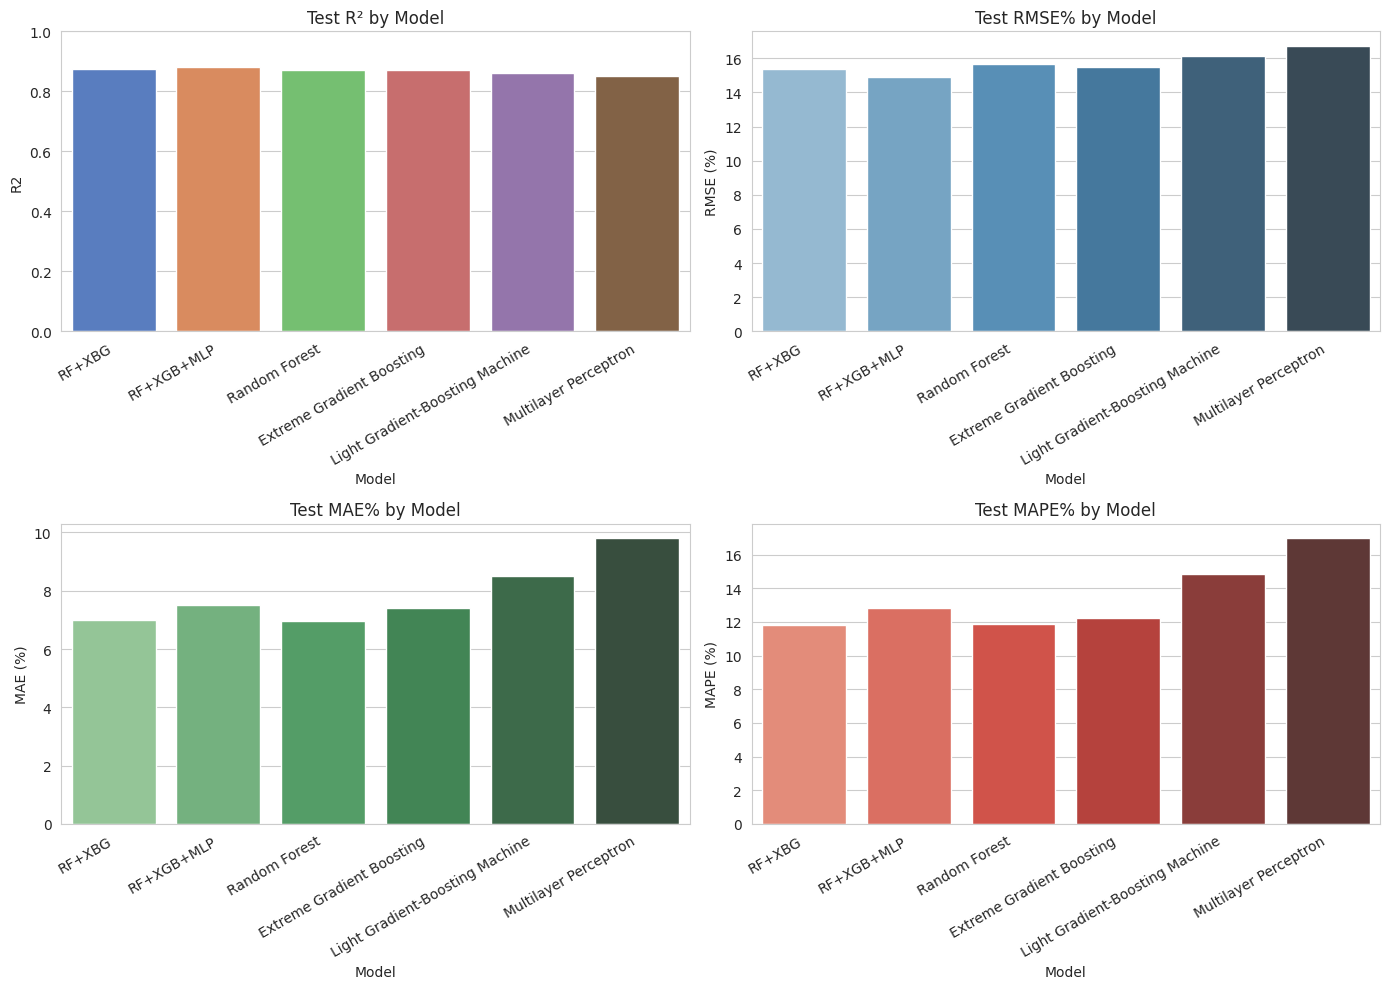

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

# 1. Load data & split
df = pd.read_csv("k_sc_opt_full_dataset.csv")
features = ["Irradiance","AmbientTemp","rload","cload",
            "Inductor","Capacitor","Vpv_avg","Ipv_avg","dV","dP"]
X = df[features].values
y = df["k_sc_opt"].values
_, X_test, _, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# 2. Load models & scaler
ensemble1      = joblib.load("/content/ensemble_rf_xgb.pkl")
ensemble2_preds= joblib.load("/content/ensemble_preds.npy")
rf_model       = joblib.load("/content/direct_rf_tuned.pkl")
xgb_model      = joblib.load("/content/direct_xgb_tuned.pkl")
lgb_model      = joblib.load("/content/direct_lgb_randsearch.pkl")
mlp_scaler     = joblib.load("/content/scaler_X_direct_mlp.pkl")
mlp_model      = load_model("/content/direct_mlp_upgraded.h5", compile=False)

# 3. Collect predictions
preds = {
    "RF+XBG":   ensemble1.predict(X_test),
    "RF+XGB+MLP":   ensemble2_preds,
    "Random Forest":      rf_model.predict(X_test),
    "Extreme Gradient Boosting":     xgb_model.predict(X_test),
    "Light Gradient-Boosting Machine":lgb_model.predict(X_test),
    "Multilayer Perceptron":  mlp_model.predict(mlp_scaler.transform(X_test)).ravel()
}

# 4. Compute metrics for each model
mean_k = y_test.mean()
records = []
for name, y_pred in preds.items():
    r2       = r2_score(y_test, y_pred)
    rmse_pct = np.sqrt(mean_squared_error(y_test, y_pred)) / mean_k * 100
    mae_pct  = mean_absolute_error       (y_test, y_pred) / mean_k * 100
    mape_pct = mean_absolute_percentage_error(y_test, y_pred) * 100
    records.append({
        "Model":     name,
        "R2":        r2,
        "RMSE (%)":  rmse_pct,
        "MAE (%)":   mae_pct,
        "MAPE (%)":  mape_pct
    })
perf_df = pd.DataFrame.from_records(records)

# 5. Plot bar charts in a 2×2 grid
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(14,10))

# R²
sns.barplot(x="Model", y="R2", data=perf_df, ax=axes[0,0], palette="muted")
axes[0,0].set_title("Test R² by Model")
axes[0,0].set_ylim(0,1)
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=30, ha="right")

# RMSE%
sns.barplot(x="Model", y="RMSE (%)", data=perf_df, ax=axes[0,1], palette="Blues_d")
axes[0,1].set_title("Test RMSE% by Model")
axes[0,1].set_ylabel("RMSE (%)")
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=30, ha="right")

# MAE%
sns.barplot(x="Model", y="MAE (%)", data=perf_df, ax=axes[1,0], palette="Greens_d")
axes[1,0].set_title("Test MAE% by Model")
axes[1,0].set_ylabel("MAE (%)")
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=30, ha="right")

# MAPE%
sns.barplot(x="Model", y="MAPE (%)", data=perf_df, ax=axes[1,1], palette="Reds_d")
axes[1,1].set_title("Test MAPE% by Model")
axes[1,1].set_ylabel("MAPE (%)")
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=30, ha="right")

plt.tight_layout()
plt.savefig("fig_all_metrics.png", dpi=300)
plt.show()
